## 5.1 Evaluating generative models
### 5.1.1 Using GPT to generate text

In [3]:
import torch

from build_a_large_language_model_from_scratch.lib.GPTModel import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # intentionally shortening it to reduce computational demands of training
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1, # it's possible and common to set dropout to 0
    "qkv_bias": False
}

cfg = GPT_CONFIG_124M

model = GPTModel(
    context_length=cfg["context_length"],
    drop_rate=cfg["drop_rate"],
    emb_dim=cfg["emb_dim"],
    n_heads=cfg["n_heads"],
    n_layers=cfg["n_layers"],
    vocab_size=cfg["vocab_size"],
    qkv_bias=cfg["qkv_bias"]
)

torch.manual_seed(123)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): LayerNorm()
          (1): MultiHeadAttention(
            (W_query): Linear(in_features=768, out_features=768, bias=False)
            (W_key): Linear(in_features=768, out_features=768, bias=False)
            (W_value): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): FeedForward(
            (layers): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU()
              (2): Linear(in_features=3072, out_features=768, bias=Tr

In [4]:
import tiktoken

from build_a_large_language_model_from_scratch.lib.generate import generate_text_simple

def text_to_token_ids(text: str, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # `unsqueeze(0)` adds batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=cfg["context_length"]
)
print(f"Output text:\n{token_ids_to_text(token_ids, tokenizer)}")

Output text:
Every effort moves you PharmacET structureguide attribution Ped prophets Theme Downing surrounded


### 5.1.2 Calculating the text generation loss

In [5]:
inputs = torch.tensor([
    [16833, 3626, 6100], # "every effort moves"
      [40, 1107, 58]])   # "I really like"

targets = torch.tensor([
    [3626, 6100, 345], # " effort moves you"
    [1107, 588, 11311] # " really like chocolate"
])

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(f"{probas.shape=}")

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(f"{token_ids=}")
print(f"{token_ids.shape=}")

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Text 1: {target_probas_1}")

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Text 2: {target_probas_2}")

probas.shape=torch.Size([2, 3, 50257])
token_ids=tensor([[[42181],
         [44128],
         [42004]],

        [[34515],
         [  525],
         [27659]]])
token_ids.shape=torch.Size([2, 3, 1])
Targets batch 1:  effort moves you
Outputs batch 1:  neurot avalancheifestyle
Text 1: tensor([1.1494e-05, 2.3580e-05, 1.9614e-05])
Text 2: tensor([5.8698e-05, 1.3303e-05, 1.2768e-05])


In [6]:
[tokenizer.decode(o) for o in token_ids.flatten(1).tolist()]

[' neurot avalancheifestyle', ' laureperclair']

In [7]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-11.3737, -10.6551, -10.8393,  -9.7431, -11.2275, -11.2686])


In [8]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8512)


In [9]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8512)


In [10]:
print(f"{logits.shape=}")
print(f"{targets.shape=}")

logits.shape=torch.Size([2, 3, 50257])
targets.shape=torch.Size([2, 3])


In [11]:
# Need to flatten for `cross_entropy` to work, so we combien them over the batch dimension:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print(f"{logits_flat.shape}")
print(f"{targets_flat.shape}")

torch.Size([6, 50257])
torch.Size([6])


In [12]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8512)


In [13]:
# Perplexity
perplexity = torch.exp(loss)
print(perplexity)

tensor(51596.8203)


### 5.1.3 Calculating the training and validation set losses

In [14]:
file_path = "./data/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [15]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"{total_characters=}")
print(f"{total_tokens=}")

total_characters=20479
total_tokens=5145


In [16]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [17]:
from build_a_large_language_model_from_scratch.lib.dataloader import create_dataloader_v1
torch.manual_seed(123)

# We use a small batch size to reduce computational resource demand because we're working with a small dataset.
# Using batch sizes of 1024 or larger is not uncommon.

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [18]:
# Check data loaders:
print("Train loader")
for x, y in train_loader:
    print(x.shape, y.shape)


print("\nValidation loader")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [19]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [20]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.025788942972818
Validation loss: 11.056291580200195


## 5.2 Training an LLM

In [22]:
from torch.utils.data import DataLoader

def train_model_simple(
    model,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer,
    device,
    num_epochs: int,
    eval_freq: int,
    eval_iter: int,
    start_context: str,
    tokenizer,
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # reset loss gradients from previous iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # calculate loss gradients
            optimizer.step()  # update model weights using the loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader: DataLoader, val_loader: DataLoader, device, eval_iter: int):
    model.eval()  # to disable dropout during evaluation
    with torch.no_grad():  # to disable gradient tracking, it's not required (reduce computational overhead)
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [23]:
torch.manual_seed(123)

model = GPTModel(
    vocab_size=cfg["vocab_size"],
    context_length=cfg["context_length"],
    drop_rate=cfg["drop_rate"],
    emb_dim=cfg["emb_dim"],
    n_heads=cfg["n_heads"],
    n_layers=cfg["n_layers"],
    qkv_bias=cfg["qkv_bias"]
)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.816, Val loss 9.924
Ep 1 (Step 000005): Train loss 8.064, Val loss 8.337
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.620, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.042, Val loss 6.599
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.510, Val loss 6.531
Ep 3 (Step 000025): Train loss 5.335, Val loss 6.374
Every effort moves you, and to the to the of the picture to the picture.                                     
Ep 4 (Step 000030): Train loss 4.685, Val loss 6.240
Ep 4 (Step 000035): Train loss 4.718, Val loss 6.350
Every effort moves you of the picture.  "I had to the picture.         "I "I to the the picture--as I had the donkey of the donkey of the donkey of the of the picture of the
Ep 5 (Step 000040): Train loss 3.860, Val loss 6.133
Every effort moves you know it was not to see a little the fact the fact of the last

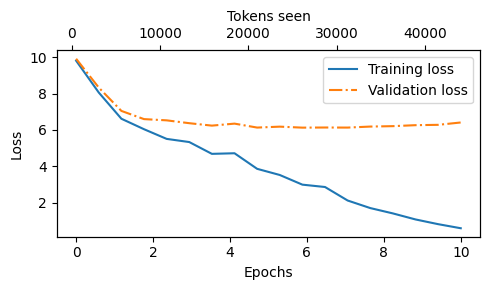

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()  # creates a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3 Decoding strategies to control randomness

In [25]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): LayerNorm()
          (1): MultiHeadAttention(
            (W_query): Linear(in_features=768, out_features=768, bias=False)
            (W_key): Linear(in_features=768, out_features=768, bias=False)
            (W_value): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): FeedForward(
            (layers): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU()
              (2): Linear(in_features=3072, out_features=768, bias=Tr

In [26]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=cfg["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.3.1 Temperature scaling

In [27]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

### 5.3.2 Top-k sampling

In [28]:
# For demonstration purposes
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [29]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(f"{top_logits=}")
print(f"{top_pos=}")
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(f"{new_logits=}")
topk_probas = torch.softmax(new_logits, dim=0)
print(f"{topk_probas=}")

top_logits=tensor([6.7500, 6.2800, 4.5100])
top_pos=tensor([3, 7, 0])
new_logits=tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
topk_probas=tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

In [30]:
from typing import Optional


def generate(model, idx, max_new_tokens: int, context_size: int, temperature=0.0, top_k: Optional[int] = None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        # Get last token in current sequence
        logits = logits[:, -1, :]
        # top-k sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float('-inf')).to(logits.device),
                other=logits
            )
        if temperature > 0.0:
            # temperature scaling
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            # greedy decoding
            idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        # check if we've reached the end
        if idx_next == eos_id:
            break
        # append generated token to current sequence for further generation
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [31]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=cfg["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I was such a good; and


## 5.4 Loading and saving model weights in PyTorch


In [32]:
torch.save(model.state_dict(), "model.pth")

In [33]:
model = GPTModel(
    vocab_size=cfg["vocab_size"],
    context_length=cfg["context_length"],
    drop_rate=cfg["drop_rate"],
    emb_dim=cfg["emb_dim"],
    n_heads=cfg["n_heads"],
    n_layers=cfg["n_layers"],
    qkv_bias=cfg["qkv_bias"]
)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

/tmp/ipykernel_26173/2634080021.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): LayerNorm()
          (1): MultiHeadAttention(
            (W_query): Linear(in_features=768, out_features=768, bias=False)
            (W_key): Linear(in_features=768, out_features=768, bias=False)
            (W_value): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): FeedForward(
            (layers): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU()
              (2): Linear(in_features=3072, out_features=768, bias=Tr

In [34]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth",
)

In [35]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(
    vocab_size=cfg["vocab_size"],
    context_length=cfg["context_length"],
    drop_rate=cfg["drop_rate"],
    emb_dim=cfg["emb_dim"],
    n_heads=cfg["n_heads"],
    n_layers=cfg["n_layers"],
    qkv_bias=cfg["qkv_bias"]
)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

/tmp/ipykernel_26173/1266802268.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): LayerNorm()
          (1): MultiHeadAttention(
            (W_query): Linear(in_features=768, out_features=768, bias=False)
            (W_key): Linear(in_features=768, out_features=768, bias=False)
            (W_value): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): FeedForward(
            (layers): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU()
              (2): Linear(in_features=3072, out_features=768, bias=Tr

## 5.5 Loading pretrained weights from OpenAI


In [36]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7f6f25e6f260>)

In [37]:
from build_a_large_language_model_from_scratch.gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

2025-01-07 17:41:39.086042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736268099.131932   26173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736268099.147918   26173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 17:41:39.277881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-01-07 17:41:48.355160: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


In [38]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [39]:
print(params["wte"])
print("Token embeddign weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embeddign weight tensor dimensions: (50257, 768)


In [40]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [41]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

In [42]:
gpt = GPTModel(
    context_length=NEW_CONFIG["context_length"],
    drop_rate=NEW_CONFIG["drop_rate"],
    emb_dim=NEW_CONFIG["emb_dim"],
    n_heads=NEW_CONFIG["n_heads"],
    n_layers=NEW_CONFIG["n_layers"],
    qkv_bias=NEW_CONFIG["qkv_bias"],
    vocab_size=NEW_CONFIG["vocab_size"]
)

gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): LayerNorm()
          (1): MultiHeadAttention(
            (W_query): Linear(in_features=768, out_features=768, bias=True)
            (W_key): Linear(in_features=768, out_features=768, bias=True)
            (W_value): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): FeedForward(
            (layers): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU()
              (2): Linear(in_features=3072, out_features=768, bias=True

In [43]:
def assign(left, right):
    """Assigns values from right tensor to left tensor after shape validation.
    
    Args:
        left: Target PyTorch tensor/parameter
        right: Source tensor/array to copy values from
        
    Returns:
        torch.nn.Parameter: New parameter containing values from right tensor
        
    Raises:
        ValueError: If shapes of left and right tensors don't match
    """
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")

    return torch.nn.Parameter(torch.tensor(right))

In [44]:
import numpy as np


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    # iterative over transformer blocks
    for b in range(len(params["blocks"])):
        # split is used to divide attention and bias weights into three equal parts for the qkv components
        # load attention qkv weights
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1
        )
        gpt.trf_blocks[b].layers[0][1].W_query.weight = assign(
            gpt.trf_blocks[b].layers[0][1].W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].layers[0][1].W_key.weight = assign(
            gpt.trf_blocks[b].layers[0][1].W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].layers[0][1].W_value.weight = assign(
            gpt.trf_blocks[b].layers[0][1].W_value.weight, v_w.T
        )

        # load attn qkv bias
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].layers[0][1].W_query.bias = assign(
            gpt.trf_blocks[b].layers[0][1].W_query.bias, q_b
        )
        gpt.trf_blocks[b].layers[0][1].W_key.bias = assign(
            gpt.trf_blocks[b].layers[0][1].W_key.bias, k_b
        )
        gpt.trf_blocks[b].layers[0][1].W_value.bias = assign(
            gpt.trf_blocks[b].layers[0][1].W_value.bias, v_b
        )

        # load attn linear projection weights
        gpt.trf_blocks[b].layers[0][1].out_proj.weight = assign(
            gpt.trf_blocks[b].layers[0][1].out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T,
        )
        gpt.trf_blocks[b].layers[0][1].out_proj.bias = assign(
            gpt.trf_blocks[b].layers[0][1].out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"],
        )

        # load feedforward network weights and biases
        gpt.trf_blocks[b].layers[1][1].layers[0].weight = assign(
            gpt.trf_blocks[b].layers[1][1].layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T,
        )
        gpt.trf_blocks[b].layers[1][1].layers[0].bias = assign(
            gpt.trf_blocks[b].layers[1][1].layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].layers[1][1].layers[2].weight = assign(
            gpt.trf_blocks[b].layers[1][1].layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T,
        )
        gpt.trf_blocks[b].layers[1][1].layers[2].bias = assign(
            gpt.trf_blocks[b].layers[1][1].layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"],
        )

        # load layer norm params
        gpt.trf_blocks[b].layers[0][0].scale = assign(
            gpt.trf_blocks[b].layers[0][0].scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].layers[0][0].shift = assign(
            gpt.trf_blocks[b].layers[0][0].shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].layers[1][0].scale = assign(
            gpt.trf_blocks[b].layers[1][0].scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].layers[1][0].shift = assign(
            gpt.trf_blocks[b].layers[1][0].shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    # Original GPT-2 model reused the token embedding weights to reduce the total number of params (weight tying)
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [45]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): LayerNorm()
          (1): MultiHeadAttention(
            (W_query): Linear(in_features=768, out_features=768, bias=True)
            (W_key): Linear(in_features=768, out_features=768, bias=True)
            (W_value): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (2): Dropout(p=0.1, inplace=False)
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): FeedForward(
            (layers): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU()
              (2): Linear(in_features=3072, out_features=768, bias=True

In [50]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I


### Exercise 5.5
Calculate the training and validation set losses of the GPTModel with the pretrained weights from OpenAI on the “The Verdict” dataset.

In [51]:
train_loss, val_loss = evaluate_model(gpt, train_loader, val_loader, device, 10)

train_loss, val_loss

(3.7547627290089927, 3.5596330165863037)